# Loading data

- Loading TESS dataset
- Extracting Features

In [1]:
from os import listdir, scandir
from os.path import join

In [2]:
wavs = [] # list of wav files path's
labels = [] # list of the corresponding labels
tess_dir = './TESS' # dataset path

# get path for all wave files 
for aud_dir in scandir(tess_dir): 
    dir_files = [join(aud_dir, f) for f in listdir(aud_dir.path)]
    wavs += dir_files
    labels += [aud_dir.name[4:].lower()] * len(dir_files)

# correcting naming error in pleasant_surprised class
labels = [l if l != 'pleasant_surprise' else 'pleasant_surprised' for l in labels]

print(f"Lengh dataset: {len(wavs)} - {len(labels)}")

Lengh dataset: 2800 - 2800


In [3]:
target_set=set(labels)
target_set

{'angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprised', 'sad'}

In [4]:
id2label = {n: l for n, l in enumerate(target_set)}
label2id = {l: n for n, l in enumerate(target_set)}

print(f"id2label: {id2label}\n\nlabel2id: {label2id}")

id2label: {0: 'fear', 1: 'sad', 2: 'neutral', 3: 'happy', 4: 'pleasant_surprised', 5: 'angry', 6: 'disgust'}

label2id: {'fear': 0, 'sad': 1, 'neutral': 2, 'happy': 3, 'pleasant_surprised': 4, 'angry': 5, 'disgust': 6}


In [5]:
encoded_labels = [label2id[l] for l in labels]
print(len(encoded_labels))

2800


## Ploting the label ocurrencies

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

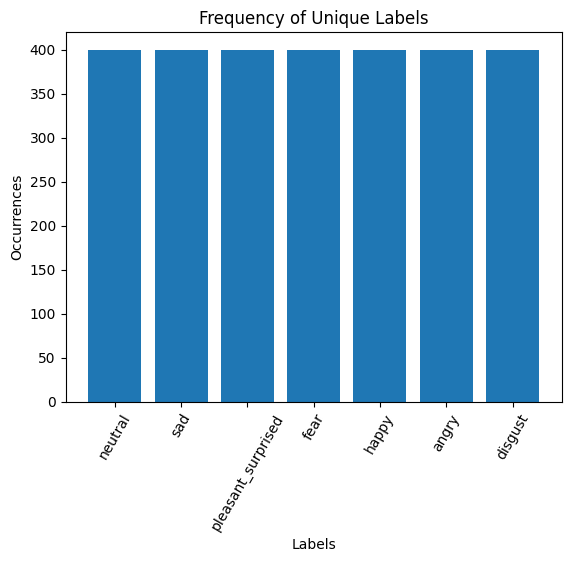

In [7]:
# Count the occurrences of each unique label
label_counts = Counter(labels)
# Extract the unique labels and their corresponding counts
unique_labels = list(label_counts.keys())
label_occurrences = list(label_counts.values())

# Plot the bar chart
plt.bar(unique_labels, label_occurrences)
plt.xlabel("Labels")
plt.ylabel("Occurrences")
plt.title("Frequency of Unique Labels")
plt.xticks(rotation=60)
plt.show()

## Extracting Audio Acoutic Features
- Zero-Crossing-Rate
- Chroma_STFT
- MFCC
- Energy Root Mean Square Value
- MelSpectogram

In [8]:
import librosa
import librosa.display
import numpy as np

In [9]:
def extract_features1(audio_file):
    data, sample_rate = librosa.load(audio_file)
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    # print(f"zcr shape {zcr.shape}")
    result=np.hstack((result, zcr)) # stacking horizontally
    # print(f"result zcr: {result}")
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # print(f"chroma_stft shape {chroma_stft.shape}")
    result = np.hstack((result, chroma_stft)) # stacking horizontally
    # print(f"result chroma_stft: {result}")

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data,n_mfcc=13, sr=sample_rate).T, axis=0)
    # print(f"MFCC shape {mfcc.shape}")
    # print(f"MFCC {mfcc}")
    result = np.hstack((result, mfcc)) # stacking horizontally
    # print(f"result mfcc: {result}")

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    # print(f"rms shape {rms.shape}")
    result = np.hstack((result, rms)) # stacking horizontally
    # print(f"result rms: {result}")

    # MelSpectogram
    melspec = librosa.feature.melspectrogram(y=data, sr=sample_rate).T
    mel = np.mean(melspec, axis=0)
    # print(f"mel shape {mel.shape}")
    # print(f"melspec shape{melspec.shape}")
    result = np.hstack((result, mel)) # stacking horizontally
    # print(f"result mel: {result}")
    
    return result

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [11]:
audio_files = wavs
labels = encoded_labels 

features_list = []
labels_list = []

# Extract features for each audio file and store them in the features_list
for audio_file, label in zip(audio_files, labels):
    features = extract_features1(audio_file)
    features_list.append(features)
    labels_list.append(label)

# Convert the lists to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
import pickle
with open('features.pkl', 'wb') as file:
    pickle.dump(X, file)

In [16]:
with open('labels.pkl', 'wb') as file:
    pickle.dump(y, file)

In [26]:
with open('train_test_split.pkl', 'wb') as file:
    pickle.dump((X_train, X_test, y_train, y_test), file)

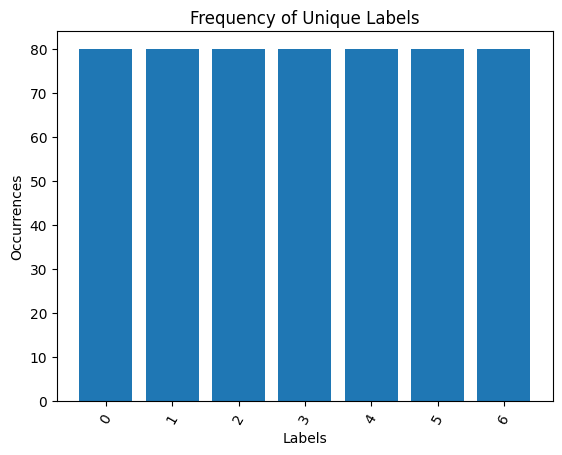

In [30]:
# Count the occurrences of each unique label
label_counts = Counter(y_test)
# Extract the unique labels and their corresponding counts
unique_labels = list(label_counts.keys())
label_occurrences = list(label_counts.values())

# Plot the bar chart
plt.bar(unique_labels, label_occurrences)
plt.xlabel("Labels")
plt.ylabel("Occurrences")
plt.title("Frequency of Unique Labels")
plt.xticks(rotation=60)
plt.show()

In [28]:
#  Create a KNN classifier and train it on the training data
model = KNeighborsClassifier(n_neighbors=5) 
model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

Confusion Matrix:
[[79  0  0  0  1  0  0]
 [ 0 74  6  0  0  0  0]
 [ 0  2 78  0  0  0  0]
 [ 1  0  0 74  5  0  0]
 [ 0  0  0  3 74  1  2]
 [ 2  0  0  0  0 78  0]
 [ 0  0  2  4  3  0 71]]
Precision: 0.9441666589586358
Recall: 0.9428571428571428
F1 Score: 0.9428931994258178
Accuracy: 0.9428571428571428


In [ ]:
# Create a SVC classifier and train it on the training data
model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

In [32]:
# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

Confusion Matrix:
[[80  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0]
 [ 0  0 80  0  0  0  0]
 [ 0  0  0 77  3  0  0]
 [ 0  0  0  0 79  0  1]
 [ 0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0 80]]
Precision: 0.9930098507334278
Recall: 0.9928571428571429
F1 Score: 0.9928555973709011
Accuracy: 0.9928571428571429


In [33]:
# Gradient Boosting
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

Confusion Matrix:
[[80  0  0  0  0  0  0]
 [ 0 78  0  1  0  0  1]
 [ 0  0 80  0  0  0  0]
 [ 0  0  0 77  3  0  0]
 [ 0  0  0  0 80  0  0]
 [ 0  0  0  0  0 79  1]
 [ 0  0  0  0  1  0 79]]
Precision: 0.9878384402193926
Recall: 0.9874999999999999
F1 Score: 0.9875303177149266
Accuracy: 0.9875


In [34]:
# Neural Network (Multi-layer Perceptron)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42)
mlp_classifier.fit(X_train, y_train)
eval_model(model, X_test, y_test)

Confusion Matrix:
[[80  0  0  0  0  0  0]
 [ 0 78  0  1  0  0  1]
 [ 0  0 80  0  0  0  0]
 [ 0  0  0 77  3  0  0]
 [ 0  0  0  0 80  0  0]
 [ 0  0  0  0  0 79  1]
 [ 0  0  0  0  1  0 79]]
Precision: 0.9878384402193926
Recall: 0.9874999999999999
F1 Score: 0.9875303177149266
Accuracy: 0.9875


## Eval

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [22]:
def eval_model(m, X_test, y_test):# Make predictions on the test data
    y_pred = m.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")